In [1]:
import os, torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
torch.manual_seed(42)

import numpy as np
import pandas as pd

from utilities import load_coordinates, load_dtm, load_mini_batches, plot_loss
from utilities import report_macro, report_class, compute_roc, compute_prc, plot_curves
%matplotlib inline

# Specify model hyperparameters

In [49]:
n_epochs = 500
batch_size = 64
lr = 0.001
weight_decay = 0.00001

# Specify plotting parameters

In [3]:
color = "#7f5b93" # Color for plotting evaluation metrics and word clouds
cmap = "Purples" # Color map for plotting brain structures
prefix = "con" # Prefix for plot file names
n_top = 15 # Number of terms (i.e., inputs) to plot per brain structure (i.e., class)
fname = "figures/style/computer-modern/cmunss.ttf" # Name of the font

# Load the data

## Brain activation coordinates

In [4]:
act_bin = load_coordinates()
n_structs = act_bin.shape[1]
print("{:12s}{}".format("Documents", act_bin.shape[0]))
print("{:12s}{}".format("Structures", n_structs))

Documents   18155
Structures  114


In [5]:
pmids = act_bin.index

# Split the data

## Training and dev sets

In [6]:
splits = {}
split_names = ["train", "dev"]
for split in split_names:
    splits[split] = [int(pmid.strip()) for pmid in open("data/splits/{}.txt".format(split), "r").readlines()]

## LSTM encodings

In [7]:
from lstm import data
import sys
sys.path.insert(0, "./lstm")

In [8]:
device = "cpu"

In [9]:
model = torch.load(open("models/lstm.pt", 'rb'), map_location=device).to(device)
model.eval()

/Users/ehbeam/anaconda/envs/ontol/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/ehbeam/anaconda/envs/ontol/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.sparse.Embedding' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/ehbeam/anaconda/envs/ontol/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.LSTM' has changed. you can retrieve the original 

RNNModel(
  (drop): Dropout(p=0.5)
  (encoder): Embedding(1543, 100)
  (rnn): LSTM(100, 100, num_layers=3, dropout=0.5)
  (decoder): Linear(in_features=100, out_features=1543, bias=True)
)

In [10]:
corpus = data.Corpus("data/text")
ntokens = len(corpus.dictionary)
n_hid = 100

In [11]:
class Document(object):
    def __init__(self, doc_words):
        self.doc = self.tokenize(doc_words)

    def tokenize(self, doc_words):
        """Tokenizes a single document."""
        doc_words += ' <eos>'
        ids = torch.LongTensor(len(doc_words.split()))
        for token, word in enumerate(doc_words.split()):
            ids[token] = corpus.dictionary.word2idx[word]
        return ids

In [12]:
docs = {split: open("data/text/corpus_{}.txt".format(split), "r").readlines() for split in split_names}

In [13]:
lstm_train_ids = [int(pmid.strip()) for pmid in open("data/text/lstm_train_pmids.txt").readlines()]

In [14]:
lstm_splits = {split: splits[split] for split in split_names}
lstm_splits["train"] = lstm_train_ids

In [15]:
cons = {}
for split in split_names:
    print("Encoding the {} set".format(split))
    con = np.zeros((len(splits[split]), n_hid))
    with torch.no_grad():  
        j = 0
        for i in range(len(docs[split])):
            if lstm_splits[split][i] in splits[split]:
                hidden = model.init_hidden(1)
                tokens = Document(docs[split][i]).doc
                for token in tokens:
                    token = token.view((1, 1))
                    output, hidden = model(token, hidden)
                con[j,:] = hidden[1][2].numpy()
                if j % 1000 == 0:
                    print("   Processed {}th document".format(j))
                j += 1
        cons[split] = con

Encoding the train set
   Processed 0th document
   Processed 1000th document
   Processed 2000th document
   Processed 3000th document
   Processed 4000th document
   Processed 5000th document
   Processed 6000th document
   Processed 7000th document
   Processed 8000th document
   Processed 9000th document
   Processed 10000th document
   Processed 11000th document
   Processed 12000th document
   Processed 13000th document
   Processed 14000th document
   Processed 15000th document
   Processed 16000th document
Encoding the dev set
   Processed 0th document


# Compute the inputs and outputs

## Inputs

Inputs are hidden layer encodings from the LSTM model.

In [17]:
X = cons["train"].transpose()

## Outputs

Outputs are labels for whether or not a given article reported a coordinate in each brain structure.

In [18]:
Y = act_bin.loc[splits["train"]].transpose().values

## Random mini-batches

In [19]:
mini_batches = load_mini_batches(X, Y, mini_batch_size=batch_size, seed=42)

# Specify the classifier

In [22]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_hid, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.fc4 = nn.Linear(100, 100)
        self.fc5 = nn.Linear(100, 100)
        self.dropout1 = nn.Dropout(p=0.5),
        self.fc6 = nn.Linear(100, 100)
        self.dropout2 = nn.Dropout(p=0.5),
        self.fc7 = nn.Linear(100, 100)
        self.dropout3 = nn.Dropout(p=0.5),
        self.fc8 = nn.Linear(100, n_structs)
        
        # Xavier initialization for weights
        for fc in [self.fc1, self.fc2, self.fc3, self.fc4,
                   self.fc5, self.fc6, self.fc7, self.fc8]:
            nn.init.xavier_uniform_(fc.weight)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.dropout(x)
        x = F.relu(self.fc6(x))
        x = F.dropout(x)
        x = F.relu(self.fc7(x))
        x = F.dropout(x)
        x = torch.sigmoid(self.fc8(x))
        return x

In [23]:
net = Net()
criterion = F.binary_cross_entropy
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

# Train the classifier

Epoch  25 	 Loss 0.005567
Epoch  50 	 Loss 0.005548
Epoch  75 	 Loss 0.005549
Epoch 100 	 Loss 0.005531
Epoch 125 	 Loss 0.005554
Epoch 150 	 Loss 0.005537
Epoch 175 	 Loss 0.005555
Epoch 200 	 Loss 0.005574
Epoch 225 	 Loss 0.005559
Epoch 250 	 Loss 0.005550
Epoch 275 	 Loss 0.005541
Epoch 300 	 Loss 0.005538
Epoch 325 	 Loss 0.005544
Epoch 350 	 Loss 0.005542
Epoch 375 	 Loss 0.005547
Epoch 400 	 Loss 0.005540
Epoch 425 	 Loss 0.005543
Epoch 450 	 Loss 0.005552
Epoch 475 	 Loss 0.005549
Epoch 500 	 Loss 0.005562


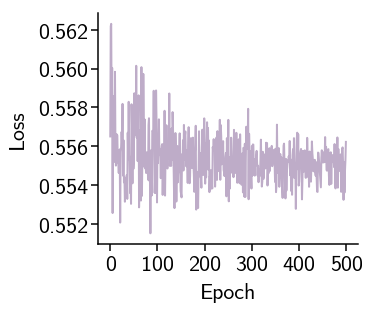

In [50]:
net_file = "models/classifier_{}.pt".format(prefix)
if not os.path.exists(net_file):
    
    running_loss = []
    for epoch in range(n_epochs):  # Loop over the dataset multiple times
        for i, data in enumerate(mini_batches):

            # Get the inputs
            inputs, labels = data
            inputs = Variable(torch.from_numpy(inputs.T).float())
            labels = Variable(torch.from_numpy(labels.T).float())

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Print running loss after each epoch
        running_loss += [loss.item()]
        if epoch % (n_epochs/20) == (n_epochs/20) - 1:
            print("Epoch {:3d} \t Loss {:6.6f}".format(epoch + 1, running_loss[-1] / 100))
    
    # Export the trained model
    torch.save(net.state_dict(), net_file)
    
    # Plot the loss
    plot_loss(prefix, running_loss, xlab="Epoch", ylab="Loss", color=color)

else:
    net.load_state_dict(torch.load(net_file))

# Evaluate the classifier

In [25]:
def report_curves(data_set, name): 
    with torch.no_grad():
        inputs, labels = data_set[0]
        inputs = Variable(torch.from_numpy(inputs.T).float())
        labels = Variable(torch.from_numpy(labels.T).float())
        pred_probs = net(inputs).float()
        fpr, tpr = compute_roc(labels, pred_probs)
        prec, rec = compute_prc(labels, pred_probs)
        plot_curves("{}_roc".format(name), fpr, tpr, diag=True, alpha=0.25,
                    color=color, xlab="1 - Specificity", ylab="Sensitivity")
        plot_curves("{}_prc".format(name), rec, prec, diag=False, alpha=0.5,
                    color=color, xlab="Recall", ylab="Precision")
        
def report_metrics(data_set):
    with torch.no_grad():
        inputs, labels = data_set[0]
        inputs = Variable(torch.from_numpy(inputs.T).float())
        labels = Variable(torch.from_numpy(labels.T).float())
        outputs = net(inputs)
        predictions = (outputs > 0.5).float() * 1
        print("-" * 50 + "\nMACRO-AVERAGED TOTAL\n" + "-" * 50)
        report_macro(labels, predictions)
        print("\n" + "-" * 50 + "\n\n")
        for i in range(n_structs):
            print("-" * 50 + "\n" + act_bin.columns[i].title().replace("_", " ") + "\n" + "-" * 50)
            report_class(labels[:,i], predictions[:,i])
            print("")

## Training set performance

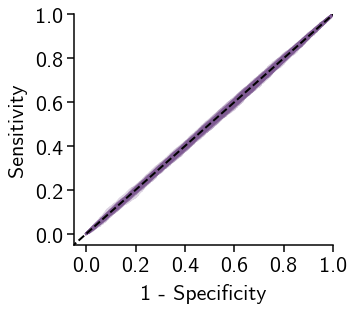

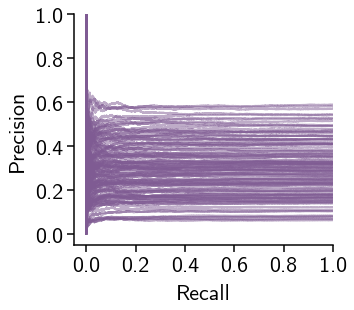

In [51]:
train_set = load_mini_batches(X, Y, mini_batch_size=len(splits["train"]), seed=42)
report_curves(train_set, "{}_train".format(prefix))

In [52]:
report_metrics(train_set)

--------------------------------------------------
MACRO-AVERAGED TOTAL
--------------------------------------------------
F1         0.0521
Precision  0.0482
Recall     0.0719
Accuracy   0.7081
ROC-AUC    0.5000

--------------------------------------------------


--------------------------------------------------
Left Frontal Pole
--------------------------------------------------
F1         0.6886
Precision  0.5251
Recall     1.0000
Accuracy   0.5251
ROC-AUC    0.5000

--------------------------------------------------
Left Insular Cortex
--------------------------------------------------
F1         0.0000
Precision  0.0000
Recall     0.0000
Accuracy   0.6259
ROC-AUC    0.5000

--------------------------------------------------
Left Superior Frontal Gyrus
--------------------------------------------------
F1         0.0022
Precision  0.6000
Recall     0.0011
Accuracy   0.5089
ROC-AUC    0.5002

--------------------------------------------------
Left Middle Frontal Gyrus
-----------

Precision  0.0000
Recall     0.0000
Accuracy   0.6488
ROC-AUC    0.5000

--------------------------------------------------
Left Parietal Operculum Cortex
--------------------------------------------------
F1         0.0000
Precision  0.0000
Recall     0.0000
Accuracy   0.6994
ROC-AUC    0.5000

--------------------------------------------------
Left Planum Polare
--------------------------------------------------
F1         0.0000
Precision  0.0000
Recall     0.0000
Accuracy   0.7952
ROC-AUC    0.5000

--------------------------------------------------
Left Heschls Gyrus
--------------------------------------------------
F1         0.0000
Precision  0.0000
Recall     0.0000
Accuracy   0.7806
ROC-AUC    0.5000

--------------------------------------------------
Left Planum Temporale
--------------------------------------------------
F1         0.0000
Precision  0.0000
Recall     0.0000
Accuracy   0.6773
ROC-AUC    0.5000

--------------------------------------------------
Left Supracal

F1         0.6888
Precision  0.5253
Recall     1.0000
Accuracy   0.5253
ROC-AUC    0.5000

--------------------------------------------------
Right Lateral Occipital Cortex Inferior Division
--------------------------------------------------
F1         0.0000
Precision  0.0000
Recall     0.0000
Accuracy   0.5886
ROC-AUC    0.5000

--------------------------------------------------
Right Intracalcarine Cortex
--------------------------------------------------
F1         0.0000
Precision  0.0000
Recall     0.0000
Accuracy   0.7541
ROC-AUC    0.5000

--------------------------------------------------
Right Frontal Medial Cortex
--------------------------------------------------
F1         0.0000
Precision  0.0000
Recall     0.0000
Accuracy   0.8369
ROC-AUC    0.5000

--------------------------------------------------
Right Supplementary Motor Cortex
--------------------------------------------------
F1         0.0000
Precision  0.0000
Recall     0.0000
Accuracy   0.7104
ROC-AUC    0.5000


## Dev set performance

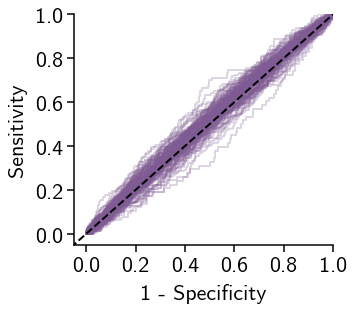

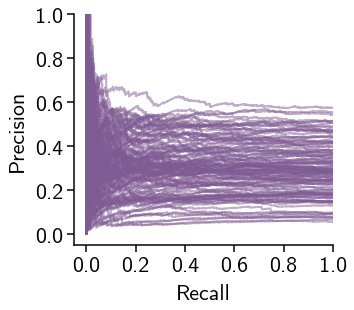

In [53]:
X_dev = cons["dev"].transpose()
Y_dev = act_bin.loc[splits["dev"]].transpose().values
dev_set = load_mini_batches(X_dev, Y_dev, mini_batch_size=len(splits["dev"]), seed=42)
report_curves(dev_set, "{}_dev".format(prefix))

In [54]:
report_metrics(dev_set)

--------------------------------------------------
MACRO-AVERAGED TOTAL
--------------------------------------------------
F1         0.0506
Precision  0.0411
Recall     0.0720
Accuracy   0.7117
ROC-AUC    0.5000

--------------------------------------------------


--------------------------------------------------
Left Frontal Pole
--------------------------------------------------
F1         0.6725
Precision  0.5066
Recall     1.0000
Accuracy   0.5066
ROC-AUC    0.5000

--------------------------------------------------
Left Insular Cortex
--------------------------------------------------
F1         0.0000
Precision  0.0000
Recall     0.0000
Accuracy   0.6211
ROC-AUC    0.5000

--------------------------------------------------
Left Superior Frontal Gyrus
--------------------------------------------------
F1         0.0000
Precision  0.0000
Recall     0.0000
Accuracy   0.5143
ROC-AUC    0.4989

--------------------------------------------------
Left Middle Frontal Gyrus
-----------

Recall     0.0000
Accuracy   0.7511
ROC-AUC    0.5000

--------------------------------------------------
Left Amygdala
--------------------------------------------------
F1         0.0000
Precision  0.0000
Recall     0.0000
Accuracy   0.8139
ROC-AUC    0.5000

--------------------------------------------------
Left Accumbens
--------------------------------------------------
F1         0.0000
Precision  0.0000
Recall     0.0000
Accuracy   0.9119
ROC-AUC    0.5000

--------------------------------------------------
Left Brainstem
--------------------------------------------------
F1         0.0000
Precision  0.0000
Recall     0.0000
Accuracy   0.9086
ROC-AUC    0.5000

--------------------------------------------------
Left Cerebellum
--------------------------------------------------
F1         0.0000
Precision  0.0000
Recall     0.0000
Accuracy   0.6960
ROC-AUC    0.5000

--------------------------------------------------
Right Frontal Pole
-------------------------------------------

Precision  0.0000
Recall     0.0000
Accuracy   0.6377
ROC-AUC    0.5000

--------------------------------------------------
Right Parahippocampal Gyrus Anterior Division
--------------------------------------------------
F1         0.0000
Precision  0.0000
Recall     0.0000
Accuracy   0.8535
ROC-AUC    0.5000

--------------------------------------------------
Right Parahippocampal Gyrus Posterior Division
--------------------------------------------------
F1         0.0000
Precision  0.0000
Recall     0.0000
Accuracy   0.8546
ROC-AUC    0.5000

--------------------------------------------------
Right Lingual Gyrus
--------------------------------------------------
F1         0.0000
Precision  0.0000
Recall     0.0000
Accuracy   0.6289
ROC-AUC    0.5000

--------------------------------------------------
Right Temporal Fusiform Cortex Anterior Division
--------------------------------------------------
F1         0.0000
Precision  0.0000
Recall     0.0000
Accuracy   0.9460
ROC-AUC    0

# Map a brain dictionary

In [55]:
from nilearn import image, plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import font_manager
from scipy.stats import zscore
from wordcloud import WordCloud
from utilities import load_atlas, mni2vox

## Compute term activation maps

Inputs are embeddings for each term. Outputs are probabilities for each brain structure predicted by the occurrence of a given term.

In [56]:
terms = list(corpus.dictionary.word2idx.keys())
term_map = pd.DataFrame(index=act_bin.columns, columns=terms)

In [57]:
with torch.no_grad():  
    for i, term in enumerate(terms):
        token = np.array(corpus.dictionary.word2idx[term])
        token = torch.from_numpy(token).view((1, 1))
        hidden = model.init_hidden(1)
        output, hidden = model(token, hidden)
        inputs = hidden[1][2]
        pred_probs = net(inputs).float().detach().numpy()[0]
        term_map[term] = pred_probs

## Load coordinates for brain structures

In [58]:
c = pd.read_csv("data/brain/labels.csv", index_col=None, header=0)
struct2coord = {}
for struct, x, y, z in zip(c["PREPROCESSED"], c["X"], c["Y"], c["Z"]):
    struct2coord[struct] = mni2vox(x, y, z)

## Plot brain maps and word clouds

In [ ]:
verbose = False
for i, struct in enumerate(act_bin.columns):
    struct = act_bin.columns[i]
    outfile = "figures/maps/{}/{}.png".format(prefix, struct)
    
    if not os.path.exists(outfile):
        x, y, z = struct2coord[struct]
        if verbose:
            print("{} (z={})".format(struct.title().replace("_", " "), int(z)))
        if not verbose:
            plt.ioff()

        fig, ax = plt.subplots(1,2, figsize=(6,6))
        gs1 = gridspec.GridSpec(1,2)
        gs1.update(wspace=-20, hspace=-10)
        fig.suptitle(c["PRESENTABLE_TITLE"][i], y=0.79,
                     fontproperties=font_manager.FontProperties(fname=fname, size=24))

        bg_img = image.load_img("data/brain/atlases/MNI152_T1_1mm_brain.nii.gz")
        bg_img = np.flip(np.rot90(bg_img.get_data()[:,:,int(z)]).astype(float), axis=1)
        bg_img[bg_img == 0] = np.nan
        bg_img = bg_img[10:198, 20:162]

        bilateral_atlas = load_atlas()
        struct_img = np.flip(np.rot90(bilateral_atlas.get_data()[:,:,int(z)]), axis=1)
        struct_img[struct_img != i+1] = np.nan
        struct_img[struct_img == i+1] = 1.0
        struct_img[struct_img == 0] = np.nan
        struct_img = struct_img[10:198, 20:162]
    
        ax[0].imshow(bg_img, cmap="Greys_r", alpha=0.7, vmin=1)
        ax[0].imshow(struct_img, cmap=cmap, alpha=0.6, vmin=0, vmax=1)
        for side in ["left", "right", "top", "bottom"]:
            ax[0].spines[side].set_visible(False)
        ax[0].set_xticks([])
        ax[0].set_yticks([])

        def color_func(word, font_size, position, orientation, 
                   random_state=None, idx=0, **kwargs):
            return color

        top = term_map.loc[struct].sort_values(ascending=False)[:n_top]
        vals = top.values
        tkns = [t.replace("_", " ") for t in top.index]
        cloud = WordCloud(background_color="rgba(255, 255, 255, 0)", mode="RGB", 
                          max_font_size=180, min_font_size=10, 
                          prefer_horizontal=1, scale=20, margin=3,
                          width=1200, height=1400, font_path=fname, 
                          random_state=42).generate_from_frequencies(zip(tkns, vals))
        ax[1].imshow(cloud.recolor(color_func=color_func, random_state=42))
        ax[1].axis("off")

        plt.savefig(outfile, bbox_inches="tight", dpi=250)
        if verbose:
            plt.show()
        plt.close()

## Combine into one figure

In [ ]:
import os
from PIL import Image, ImageOps

In [ ]:
images = ["figures/maps/{}/{}.png".format(prefix, struct) for struct in act_bin.columns]
img_w, img_h = Image.open(images[0]).size

In [ ]:
pad_w, pad_h = 60, 30
img_w += pad_w * 2
img_h += pad_h * 2
n_row, n_col = 19, 6
fig_w = n_col * img_w
fig_h = n_row * img_h
x_coords = list(range(0, fig_w, img_w)) * n_row
y_coords = np.repeat(list(range(0, fig_h, img_h)), n_col)
padding = (pad_w, pad_h, pad_w, pad_h)
white = (255,255,255,0)

In [ ]:
figure = Image.new("RGB", (fig_w, fig_h), color=white)
for i, img in enumerate(images):
    img = Image.open(img)
    img = ImageOps.expand(img, padding, fill=white)
    figure.paste(img, (x_coords[i], y_coords[i]))
figure.save("figures/maps/{}_map.png".format(prefix))
figure